In [1]:
import numpy as np
from keras_preprocessing.sequence import pad_sequences
import numpy as np 
import tensorflow as tf
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
#from keras.preprocessing.text import Tokenizer|
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from keras.datasets import imdb


In [2]:
seed = 7
print(seed)

7


In [45]:
from sklearn.model_selection import train_test_split
from keras.datasets import imdb

# Загрузка данных
max_features = 2000
(x_data1, y_data1), (x_data2, y_data2) = imdb.load_data(num_words=max_features,seed=seed)

In [60]:
max_review_length = 300
x_data = np.concatenate([x_data1, x_data2], axis=0)
y_data = np.concatenate([y_data1, y_data2], axis=0)
x_data = pad_sequences(x_data, maxlen=max_review_length,value = 0,padding = 'post', truncating='post')
x_data = x_data[:int(len(x_data)*0.3)]
y_data = y_data[:int(len(y_data)*0.3)]

In [61]:

x_train, x_temp, y_train, y_temp = train_test_split(x_data, y_data, test_size=0.15, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.2, random_state=42)

# Проверка размеров выборок
print(x_train.shape, x_val.shape, x_test.shape)

(12750, 300) (1800, 300) (450, 300)


In [62]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D,MaxPooling1D, Dense, Dropout
from keras import regularizers
embedding_vecor_length = 300
# Модель
model_cnn = Sequential([
    Embedding(input_dim=max_features, output_dim=embedding_vecor_length,input_length=max_review_length),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    #MaxPooling1D(5),
    #Conv1D(filters=64, kernel_size=5, activation='relu'),Dropout(0.5),
    GlobalMaxPooling1D(),
    Dense(10, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_cnn.summary()
# Обучение



Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 300, 300)          600000    
                                                                 
 conv1d_33 (Conv1D)          (None, 296, 128)          192128    
                                                                 
 global_max_pooling1d_13 (G  (None, 128)               0         
 lobalMaxPooling1D)                                              
                                                                 
 dense_38 (Dense)            (None, 10)                1290      
                                                                 
 dropout_20 (Dropout)        (None, 10)                0         
                                                                 
 dense_39 (Dense)            (None, 1)                 11        
                                                     

In [63]:
# Обучение
history_cnn  = model_cnn.fit(
    x_train, y_train,
    epochs=10,
    batch_size=64,verbose =1,validation_data=(x_val,y_val)
)

Epoch 1/10
200/200 [==============================] - 16s 73ms/step - loss: 0.6329 - accuracy: 0.6346 - val_loss: 0.4919 - val_accuracy: 0.8000
Epoch 2/10
200/200 [==============================] - 15s 75ms/step - loss: 0.4444 - accuracy: 0.8204 - val_loss: 0.3599 - val_accuracy: 0.8606
Epoch 3/10
200/200 [==============================] - 17s 83ms/step - loss: 0.3556 - accuracy: 0.8770 - val_loss: 0.3292 - val_accuracy: 0.8689
Epoch 4/10
200/200 [==============================] - 20s 98ms/step - loss: 0.2665 - accuracy: 0.9075 - val_loss: 0.3361 - val_accuracy: 0.8589
Epoch 5/10
200/200 [==============================] - 17s 86ms/step - loss: 0.2086 - accuracy: 0.9285 - val_loss: 0.3306 - val_accuracy: 0.8678
Epoch 6/10
200/200 [==============================] - 16s 78ms/step - loss: 0.1561 - accuracy: 0.9471 - val_loss: 0.3723 - val_accuracy: 0.8706
Epoch 7/10
200/200 [==============================] - 17s 85ms/step - loss: 0.1310 - accuracy: 0.9553 - val_loss: 0.3906 - val_accuracy:

# Оценка моделей

In [66]:
y_pred_cnn = (model_cnn.predict(x_test) > 0.5).astype(int)

15/15 [==============================] - 0s 10ms/step


CNN Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       227
           1       0.89      0.91      0.90       223

    accuracy                           0.90       450
   macro avg       0.90      0.90      0.90       450
weighted avg       0.90      0.90      0.90       450



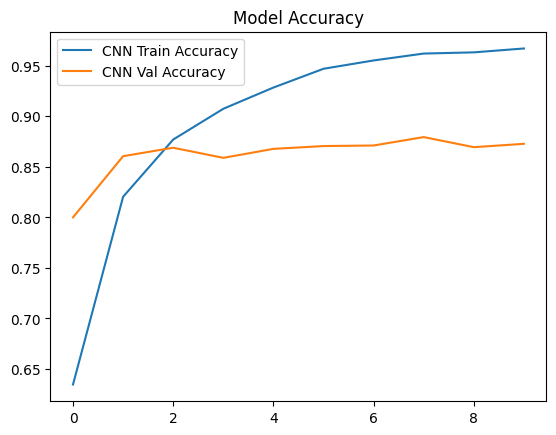

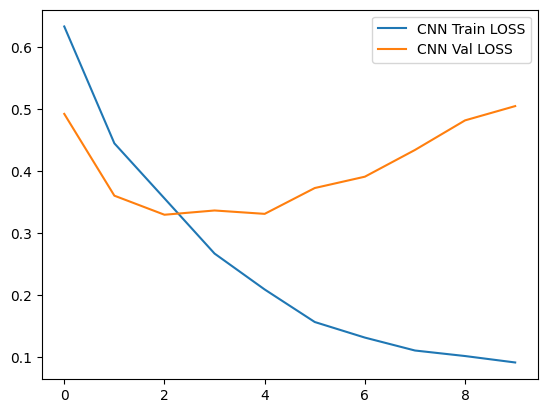

In [71]:
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt
print("CNN Classification Report:")
print(classification_report(y_test, y_pred_cnn,zero_division=0))
plt.plot(history_cnn.history['accuracy'], label='CNN Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='CNN Val Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()
plt.plot(history_cnn.history['loss'], label='CNN Train LOSS')
plt.plot(history_cnn.history['val_loss'], label='CNN Val LOSS')
plt.legend()

plt.show()